In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bluebook-for-bulldozers/Valid.7z
/kaggle/input/bluebook-for-bulldozers/Valid.zip
/kaggle/input/bluebook-for-bulldozers/Train.zip
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv
/kaggle/input/bluebook-for-bulldozers/median_benchmark.csv
/kaggle/input/bluebook-for-bulldozers/Valid.csv
/kaggle/input/bluebook-for-bulldozers/Machine_Appendix.csv
/kaggle/input/bluebook-for-bulldozers/random_forest_benchmark_test.csv
/kaggle/input/bluebook-for-bulldozers/Data Dictionary.xlsx
/kaggle/input/bluebook-for-bulldozers/ValidSolution.csv
/kaggle/input/bluebook-for-bulldozers/Test.csv
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.zip
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.7z
/kaggle/input/bluebook-for-bulldozers/Train.7z


In [2]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *

In [3]:
path = "/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv"

In [4]:
df = pd.read_csv(path,low_memory=False)

In [5]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [8]:
df['ProductSize'].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [9]:
sizes = ('Large','Large / Medium','Medium','Small','Mini','Compact')

In [10]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [11]:
df['ProductSize'].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [12]:
target = 'SalePrice'
df[target] = np.log(df[target])

In [13]:
# replace every date column with a set of date metadata columns, such as holiday, day of week, and month
df = add_datepart(df, 'saledate')

In [14]:
# Let’s do the same for the test set while we’re there:
df_test = pd.read_csv("/kaggle/input/bluebook-for-bulldozers/Test.csv", low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [15]:
# We can see that there are now lots of new columns in our DataFrame:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called **TabularPandas** and **TabularProc**.

## Using TabularPandas and TabularProc

In [16]:
procs = [Categorify, FillMissing]

TabularPandas will also handle splitting the dataset into training and validation sets for us. However, we need to be very careful about our validation set. We want to design it so that it is like the test set Kaggle will use to judge the contest.

### Validation set vs Test set
A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that we don’t overfit on the validation data as we explore various model architectures and hyperparameters.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.

If you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset that consists only of the Kaggle training data from before November 2011, and we’ll define a validation set consisting of data from after November 2011.


In [17]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_index = np.where(cond)[0]
valid_index = np.where(~cond)[0]

In [18]:
splits = (list(train_index),list(valid_index))

**TabularPandas** needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [19]:
cont,cat = cont_cat_split(df, 1, dep_var=target)
print(cont)
print(cat)

['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saleYear', 'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear', 'saleElapsed']
['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls', 'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleI

In [20]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat,
                   cont_names = cont,
                   y_names=target,
                   splits = splits)

A TabularPandas behaves a lot like a fastai Datasets object, including providing train and valid attributes:

In [21]:
print(df.shape)
print(len(to.train))
print(len(to.valid))

(412698, 65)
404710
7988


We can see that the data is still displayed as strings for categories (we show only a few columns here because the full table is too big to fit on a page):

In [22]:
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246.0,999089.0,3157.0,121.0,3.0,2004.0,68.0,2006.0,11.0,46.0,16.0,3.0,320.0,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248.0,117657.0,77.0,121.0,3.0,1996.0,4640.0,2004.0,3.0,13.0,26.0,4.0,86.0,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249.0,434808.0,7009.0,121.0,3.0,2001.0,2838.0,2004.0,2.0,9.0,26.0,3.0,57.0,1.077754e+09,9.210340
3,High,PC120-6E,PC120,#na#,-6E,#na#,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,#na#,EROPS w AC,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139251.0,1026470.0,332.0,121.0,3.0,2001.0,3486.0,2011.0,5.0,20.0,19.0,3.0,139.0,1.305763e+09,10.558414
4,Medium,S175,S175,#na#,#na#,#na#,#na#,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,EROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139253.0,1057373.0,17311.0,121.0,3.0,2007.0,722.0,2009.0,7.0,30.0,23.0,3.0,204.0,1.248307e+09,9.305651


However, the underlying items are all numeric:

In [23]:
to.items.head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,-0.834058,11.097410,-0.500092,-0.601280,-1.508141,-0.202014,0.359745,-0.070798,2,963,...,1.422504,1,1,1,1,1,1,0.382991,1,1
1,-0.834056,10.950807,-2.478315,-1.095297,-1.508141,-0.202014,0.332374,0.206743,2,1745,...,-0.855193,1,1,1,1,1,1,-0.073841,1,1
2,-0.834055,9.210340,-1.766524,0.016563,-1.508141,-0.202014,0.349481,0.097353,1,336,...,-1.137472,1,1,1,1,1,1,-0.087569,1,1
3,-0.834053,10.558414,-0.438640,-1.054397,-1.508141,-0.202014,0.349481,0.136690,1,3716,...,-0.339304,1,1,1,1,1,1,1.161734,1,1
4,-0.834051,9.305651,-0.369284,1.668957,-1.508141,-0.202014,0.370009,-0.031098,3,4261,...,0.293389,1,1,1,1,1,1,0.846923,1,1


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there’s no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for ProductSize earlier), in which case the ordering you chose is used. We can see the mapping by looking at the classes attribute:

In [24]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

Since it takes a minute or so to process the data to get to this point, we should save it —that way, in the future, we can continue our work from here without rerunning the previous steps. fastai provides a save method that uses Python’s pickle system to save nearly any Python object:

In [25]:
import pickle
pickle.dump(to,open("/kaggle/working/to.pkl","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
to = pickle.load(open("/kaggle/working/to.pkl","rb"))

In [27]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

## Creating the Decision Tree
We define our independent and dependent variables:

In [28]:
# train_independent data, train_dependent data
xs,y = to.train.xs,to.train.y

# validation_independent data, validation_dependent data
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [29]:
from sklearn.tree import DecisionTreeRegressor,plot_tree

model = DecisionTreeRegressor(max_leaf_nodes = 4) # model instantiation
model.fit(xs, y); # model training

To keep it simple, we’ve told sklearn to create just four leaf nodes. To see what it’s learned, we can display the tree:


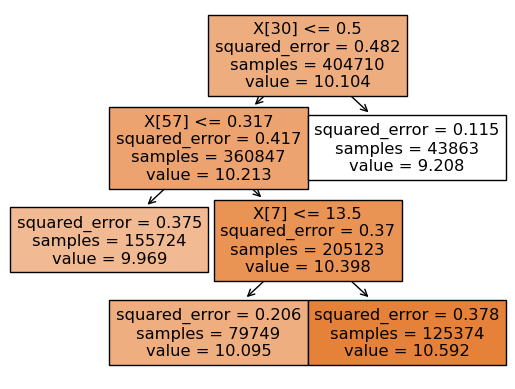

In [30]:
plot_tree(model,filled=True);

In [31]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean())) 

def m_rmse(model, xs, y): 
    return r_mse(model.predict(xs), y)

In [32]:
m_rmse(model, xs, y)

1

So, our model is perfect, right? Not so fast...remember, we really need to check the validation set, to ensure we’re not overfitting:

In [33]:
m_rmse(model, valid_xs, valid_y)

1

Oops—it looks like we might be overfitting pretty badly. Here’s why:

In [34]:
model.get_n_leaves(), len(xs)

(4, 404710)

## Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [37]:
model = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the DecisionTreeRegressor, which made just one tree using all the available data:

In [38]:
m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)

(0, 0)

In [39]:
model.feature_importances_

array([5.68315827e-04, 3.38851904e-02, 2.14870879e-02, 4.57944127e-02,
       4.36572342e-03, 2.69788688e-02, 9.68190494e-02, 8.25655237e-02,
       4.79516201e-03, 1.10658386e-02, 4.72259490e-03, 9.57150630e-03,
       4.07861390e-02, 2.48934897e-04, 2.19192662e-04, 7.12513297e-04,
       2.50764765e-03, 1.02068330e-03, 2.50400295e-04, 5.64484567e-04,
       5.64269314e-04, 2.59604563e-04, 1.61775475e-04, 8.75903116e-03,
       1.66658285e-03, 3.45924634e-03, 1.04017413e-03, 2.47195020e-04,
       8.98491404e-03, 1.85950824e-03, 1.07239291e-01, 6.16270471e-02,
       3.53336891e-02, 4.40975978e-03, 9.52597261e-04, 2.11350721e-03,
       8.26567638e-04, 9.99724126e-04, 3.68470295e-04, 2.81908318e-04,
       1.93834280e-03, 1.65818599e-03, 2.67147483e-04, 1.72090156e-04,
       2.87035168e-05, 1.49034520e-05, 8.22818936e-06, 3.80131024e-06,
       0.00000000e+00, 0.00000000e+00, 1.00058303e-04, 6.06239613e-04,
       2.40827994e-02, 1.85536262e-02, 5.64030584e-02, 1.11654297e-03,
      

In [40]:
fi = pd.DataFrame({"cols":xs.columns,"importance":model.feature_importances_}).sort_values("importance",ascending=False)
fi[:30]

,cols,importance
57,YearMade,0.173077
30,Coupler_System,0.107239
6,ProductSize,0.096819
7,fiProductClassDesc,0.082566
31,Grouser_Tracks,0.061627
54,ModelID,0.056403
65,saleElapsed,0.049184
3,fiSecondaryDesc,0.045794
12,Enclosure,0.040786
32,Hydraulics_Flow,0.035334


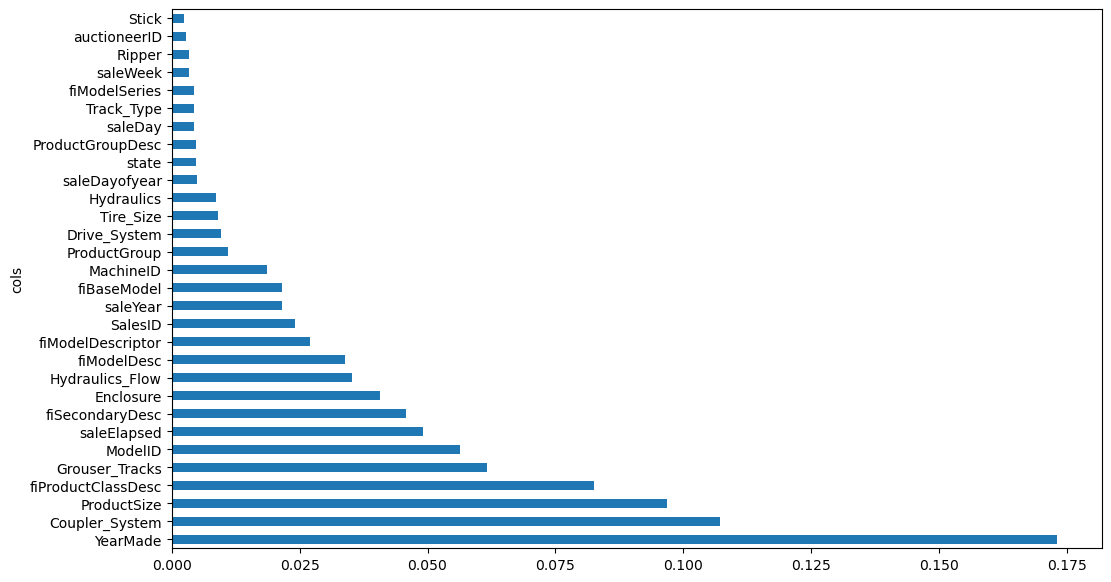

In [41]:
def plot_fi(fi):    
    fi.plot('cols', 'importance', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])

## Removing Low-Importance Variables


In [42]:
to_keep = fi[fi["importance"] > 0.005]["cols"]
print(len(to_keep))
to_keep

20


57              YearMade
30        Coupler_System
6            ProductSize
7     fiProductClassDesc
31        Grouser_Tracks
54               ModelID
65           saleElapsed
3        fiSecondaryDesc
12             Enclosure
32       Hydraulics_Flow
1            fiModelDesc
5      fiModelDescriptor
52               SalesID
59              saleYear
2            fiBaseModel
53             MachineID
9           ProductGroup
11          Drive_System
28             Tire_Size
23            Hydraulics
Name: cols, dtype: object

We can retrain our model using just this subset of the columns:

In [43]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [44]:
model = rf(xs_imp, y)

And here’s the result:

In [45]:
m_rmse(model, xs_imp, y), m_rmse(model, valid_xs_imp, valid_y)

(0, 0)

Our accuracy is about the same, but we have far fewer columns to study:

In [46]:
len(xs.columns), len(xs_imp.columns)

(66, 20)

This also makes our feature importance plot easier to interpret. Let’s look at it again:
  